<a href="https://colab.research.google.com/github/EricEricEricJin/ECE539-Group-Project/blob/master/music_speech_clf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from google.colab import drive

drive.mount("/content/drive")
# audio_binary = tf.io.read_file(fp)
# drive.flush_and_unmount()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Reference: [Classifying Music and Speech with Machine Learning](https://medium.com/m2mtechconnect/classifying-music-and-speech-with-machine-learning-e036ffab002e)


In [ ]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython import display
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models

fp = "/content/drive/My Drive/Colab Notebooks/ECE539_Project"

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  return parts[-2]

filename_list = []
for dirname, _, filenames in os.walk(fp):
    if "xxm_singing" in dirname or "xxm_speech" in dirname:
        print(dirname)
        for filename in filenames:
            filename_list.append(os.path.join(dirname, filename))

train_files, val_files = train_test_split(filename_list, train_size=0.75,
  shuffle=True, stratify=[get_label(fp)=='xxm_speech' for fp in filename_list])

categories = ['xxm_speech', 'xxm_singing']
get_label(filename_list[0]) == "xxm_speech"

/content/drive/My Drive/Colab Notebooks/ECE539_Project/xxm_singing
/content/drive/My Drive/Colab Notebooks/ECE539_Project/xxm_speech


<tf.Tensor: shape=(), dtype=bool, numpy=False>

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary) # returns the WAV-encoded audio as a tensor and the sample rate
  return tf.squeeze(audio, axis=-1) # removes dimensions of size 1 from the

In [ ]:
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)

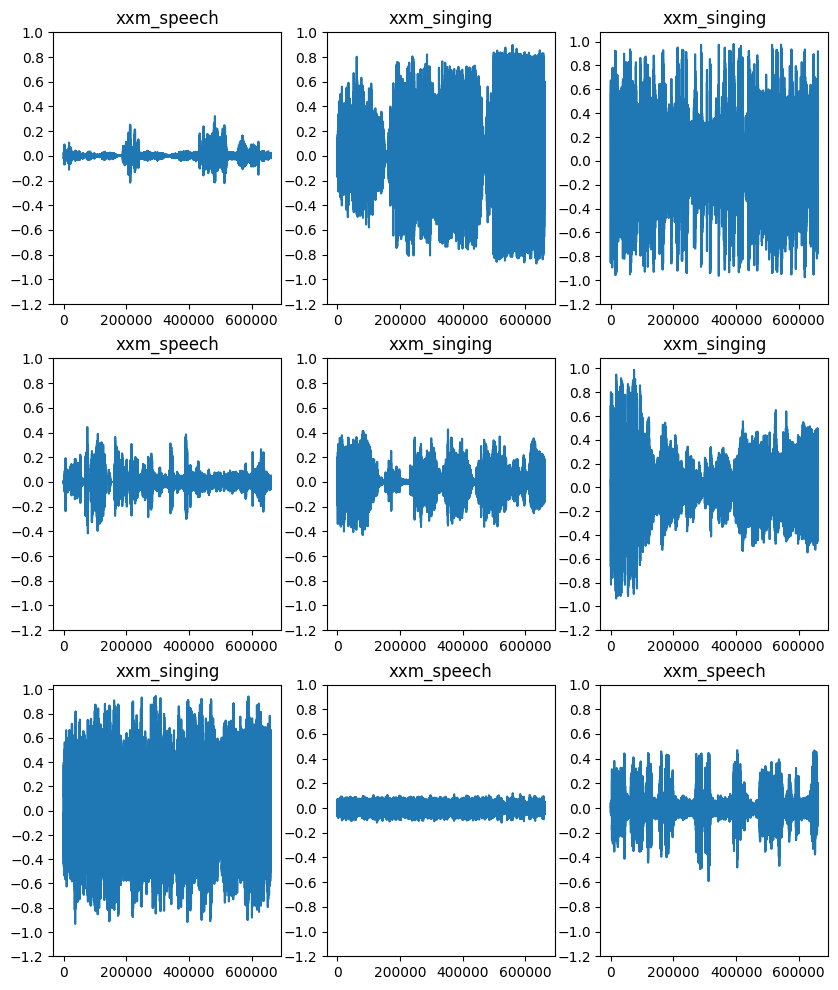

In [ ]:
rows=3
cols=3
n=rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
    r=i // cols
    c=i % cols
    ax = axes[r][c]
    ax.plot(audio.numpy())
    ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
    label = label.numpy().decode('utf-8')
    ax.set_title(label)
plt.show()

In [ ]:
def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(
        waveform, frame_length=255, frame_step=128)
    # removes the phase (we only care about the magnitude)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

for waveform, label in waveform_ds.take(1):
    label = label.numpy().decode('utf-8')
    spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)

Label: xxm_speech
Waveform shape: (661500,)
Spectrogram shape: (5166, 129)


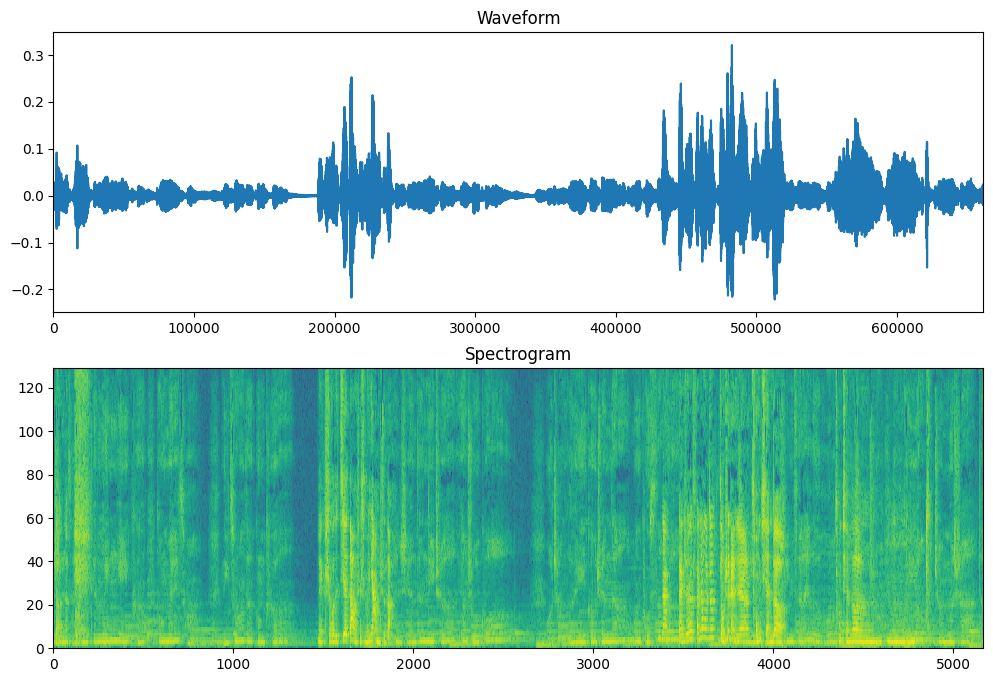

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  ax.pcolormesh(log_spec)

fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 661500])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == categories)
  return spectrogram, label_id

spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)


def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=tf.data.AUTOTUNE)
  return output_ds


train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)

In [ ]:
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

for spectrogram, _ in spectrogram_ds.take(1):
    input_shape = spectrogram.shape

print('Input shape:', input_shape)
num_labels = len(categories)

Input shape: (5166, 129, 1)


In [ ]:
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(64, 64),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 8
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 64, 64, 1)         0         
                                                                 
 normalization (Normalizati  (None, 64, 64, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0

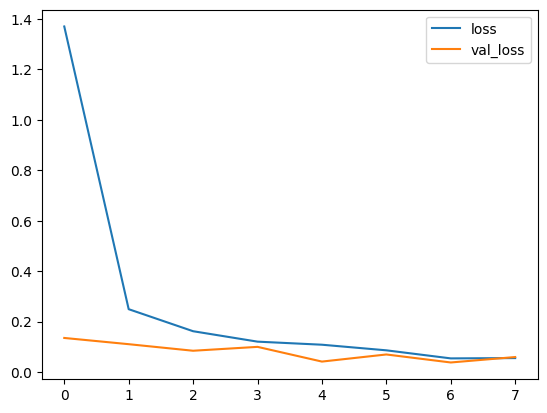

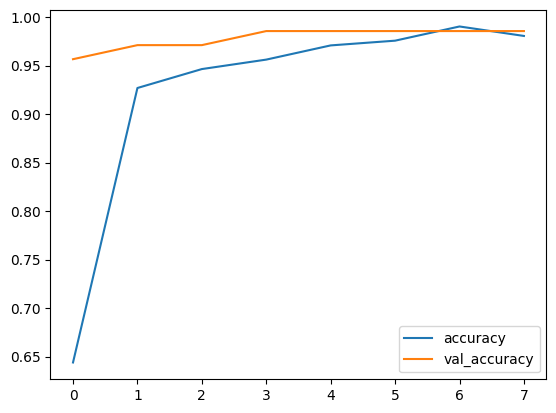

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

metrics = history.history
plt.plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

## Apply to singing-speech mixed audio

In [ ]:
waveform, _ = get_waveform_and_label(
    "/content/drive/My Drive/Colab Notebooks/ECE539_Project/xxm_mixed/BV1bT411S7ck.wav")


In [ ]:
CHUNK_SIZE = 661500
STEP_SIZE = CHUNK_SIZE // 2
len(waveform)

pred_list = []

model_input_list = []
for i in range((len(waveform) - CHUNK_SIZE) // STEP_SIZE + 1):
  wave_ith = waveform[i * STEP_SIZE : i * STEP_SIZE + CHUNK_SIZE]
  model_input_list.append(tf.expand_dims(get_spectrogram(wave_ith), -1))

In [ ]:
# for i in range((len(waveform) - CHUNK_SIZE) // STEP_SIZE + 1):
#   wave_ith = waveform[i * STEP_SIZE : i * STEP_SIZE + CHUNK_SIZE]
#   # transfer to spectrum
#   spect = tf.expand_dims(get_spectrogram(wave_ith), -1)

#   model_input = tf.reshape(spect, (1, 5166, 129, 1))
#   pred = model.predict(model_input)
#   pred_list.append(pred)

pred_list = model.predict(tf.reshape(model_input_list, (len(model_input_list), 5166, 129, 1)))
pred_list.shape

22/22 [==============================] - 1s 54ms/step


(673, 2)

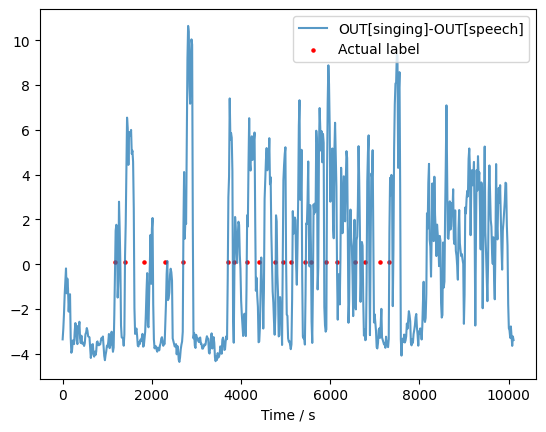

In [ ]:
marker = np.loadtxt(
    "/content/drive/My Drive/Colab Notebooks/ECE539_Project/xxm_mixed/BV1bT411S7ck.csv",
    delimiter=',')
marker

marker = marker[:,0] * 3600 + marker[:,1] * 60 + marker[:,2]
marker

plt.xlabel("Time / s")

plt.plot(np.linspace(0, 10111, len(pred_list)), pred_list[:,1] - pred_list[:,0], alpha=0.75, label="OUT[singing]-OUT[speech]")
plt.scatter(marker, np.zeros(len(marker)) + 0.1, c='r', s=5, label="Actual label")
plt.legend()
plt.show()

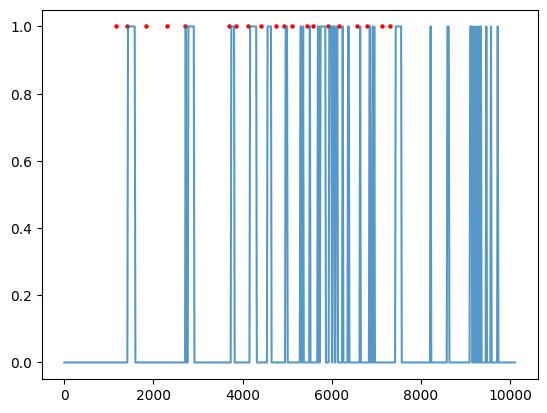

In [ ]:
threshold = 4
plt.plot(np.linspace(0, 10111, len(pred_list)), pred_list[:,1] - pred_list[:,0] > threshold, alpha=0.75, label="OUT[singing]-OUT[speech]")
plt.scatter(marker, np.ones(len(marker)), c='r', s=5, label="Actual label")

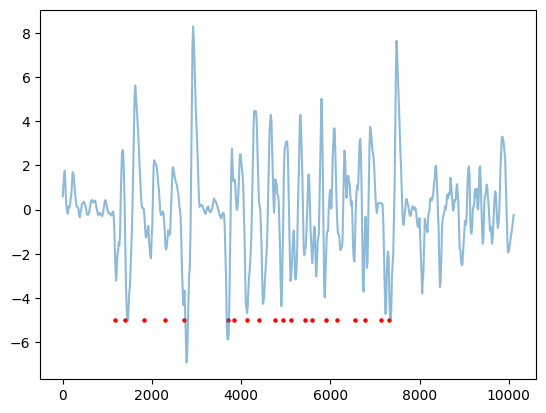

In [ ]:
### << Filter the output >> ###
filter = np.array([-2.5, -2.5, -2.5, -2.5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
filter = filter / len(filter)
pred_sub = pred_list[:,1] - pred_list[:,0]
filter_out = np.convolve(pred_sub, filter)

plt.plot(np.linspace(0, 10111, len(filter_out)), filter_out, alpha=0.5)

plt.scatter(marker, np.zeros(len(marker)) - 5, c='r', s=5)

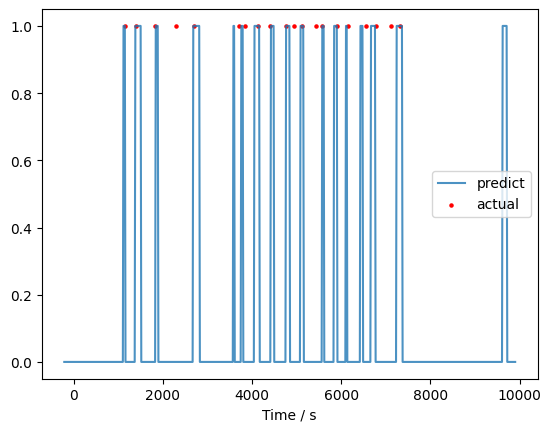

In [ ]:
threshold = 2

plt.figure()
plt.xlabel("Time / s")
plt.plot(np.linspace(0, 10111, len(filter_out)) - ((STEP_SIZE/22050)*len(filter)), filter_out > threshold, alpha=0.8, label="predict")

plt.scatter(marker, np.ones(len(marker)) , c='r', s=5, label="actual")
plt.legend()
plt.show()

In [ ]:
outcome = filter_out > threshold
(np.array(np.where(outcome == 1)) - len(filter)) * STEP_SIZE / 22050

array([[1140., 1155., 1170., 1410., 1425., 1440., 1455., 1470., 1485.,
        1500., 1515., 1530., 1875., 1890., 1905., 1920., 2730., 2745.,
        2760., 2775., 2790., 2805., 2820., 2835., 2850., 2865., 3645.,
        3660., 3825., 3840., 3855., 4125., 4140., 4155., 4170., 4185.,
        4200., 4215., 4230., 4500., 4515., 4530., 4545., 4560., 4845.,
        4860., 4875., 4890., 4905., 4920., 5175., 5190., 5205., 5220.,
        5235., 5670., 5685., 5700., 5940., 5955., 5970., 5985., 6000.,
        6210., 6225., 6540., 6555., 6570., 6585., 6780., 6795., 6810.,
        6825., 6840., 6855., 6870., 7365., 7380., 7395., 7410., 7425.,
        7440., 7455., 7470., 7485., 9780., 9795., 9810., 9825., 9840.,
        9855., 9870.]])